In [1]:
#IMPORTS
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

2024-10-02 10:12:33.768001: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Loading and Filtering the Reviews Data
This code loads the reviews dataset, filters reviews with specific ratings (1, 2, 4, 5), and classifies the reviews as 'Positive' or 'Negative' based on the rating. Finally, it selects 10 random reviews for display.


In [2]:
# Load the reviews data with the correct encoding
file_path = 'HARD-Arabic-Dataset-master/data/balanced-reviews.txt'  # Update with your actual file path
df = pd.read_csv(file_path, sep='\t', names=['no', 'Hotel name', 'rating', 'user type', 'room type', 'nights', 'review'], skiprows=1, encoding='utf-16')

# Continue with filtering and classifying as before
df_filtered = df[df['rating'].isin([1, 2, 4, 5])]
selected_reviews = df_filtered.sample(n=10)

def classify_review(row):
    if row['rating'] in [4, 5]:
        return 'Positive'
    elif row['rating'] in [1, 2]:
        return 'Negative'

selected_reviews['classification'] = selected_reviews.apply(classify_review, axis=1)
selected_reviews[['no','review', 'rating', 'classification']]


,no,review,rating,classification
57655,224093,ضعيف جداً. حجزت ولما وصلت س 11 الظهر قالو لي ا...,1,Negative
42574,163946,رائع. النظافه ممتازه والموقع ممتاز قريب من بوا...,4,Positive
1691,6102,“رحلة ممتازة”. كل شي جميل ومناسب. النظافة,4,Positive
28639,110480,استثنائي. كل شي لا شي. لا شي,5,Positive
54029,211397,رائع. تسجيل دخول+ خروج سريع جدا جدا-- كلمتهم م...,4,Positive
45974,177181,“شكرا لكم”. الإفطار وخدمة العاملين بالمطعم. نظ...,4,Positive
100552,393253,“الفندق لايستحق”. . الخدمات والنظافه والمستوى ...,2,Negative
78127,303053,رائع. ممتاز غالبا. صغر السريرازعاج الشارع,4,Positive
67212,259780,مخيب للأمل. . النظافه,2,Negative
43893,168993,“انصح بالاقامة”. طيب التعامل. ونظافة المكان.,4,Positive


### Load, Filter, and Split Reviews Dataset
This code loads the reviews dataset, filters reviews based on specific ratings (1, 2, 4, and 5), and limits the total number of reviews to a maximum of 1000. It classifies the reviews as 'Positive' or 'Negative' based on their rating, saves the classified data to a CSV file, and then splits the dataset into 70% training and 30% testing data, saving them as separate CSV files.


In [3]:
# Set the maximum number of reviews to use
max_reviews = 1000

# Load the reviews data with the correct encoding
file_path = 'HARD-Arabic-Dataset-master/data/balanced-reviews.txt'  # Update with your actual file path
df = pd.read_csv(file_path, sep='\t', names=['no', 'Hotel name', 'rating', 'user type', 'room type', 'nights', 'review'], skiprows=1, encoding='utf-16')

# Filter reviews with ratings 1, 2, 4, and 5
df_filtered = df[df['rating'].isin([1, 2, 4, 5])]

# Limit the number of reviews if max_reviews is set
if max_reviews is not None:
    df_filtered = df_filtered.head(max_reviews)

# Function to classify reviews based on the rating
def classify_review(row):
    if row['rating'] in [4, 5]:
        return 'Positive'
    elif row['rating'] in [1, 2]:
        return 'Negative'

# Apply classification function to the dataset
df_filtered['classification'] = df_filtered.apply(classify_review, axis=1)

# Select necessary columns (id, review text, classification)
df_classified = df_filtered[['no', 'review', 'classification']]

# Save the classified reviews to a CSV file
output_file = 'classified.csv'
df_classified.to_csv(output_file, index=False, encoding='utf-16')

# Split the data into 70% training and 30% testing
train_data, test_data = train_test_split(df_classified, test_size=0.3, random_state=42)

# Save the split datasets
train_data.to_csv('train_reviews.csv', index=False, encoding='utf-16')
test_data.to_csv('test_reviews.csv', index=False, encoding='utf-16')

print(f"Data saved to {output_file}, and split into train_reviews.csv and test_reviews.csv.")


Data saved to classified.csv, and split into train_reviews.csv and test_reviews.csv.


### Load, Tokenize, and Train Arabic BERT Model
This code loads the training and testing datasets, applies label encoding for 'Positive' and 'Negative' reviews, and tokenizes the review texts using a pre-trained Arabic BERT tokenizer. The data is then converted into Hugging Face dataset format. A BERT model for binary classification is loaded, training arguments are set, and a `Trainer` is defined for training and evaluating the model. The model is trained and evaluated, and then saved for future use.


In [4]:
# Load the classified train and test data
train_file = 'train_reviews.csv'
test_file = 'test_reviews.csv'

train_df = pd.read_csv(train_file, encoding='utf-16')
test_df = pd.read_csv(test_file, encoding='utf-16')

# Labeling the data (1 for Positive, 0 for Negative)
train_df['label'] = train_df['classification'].apply(lambda x: 1 if x == 'Positive' else 0)
test_df['label'] = test_df['classification'].apply(lambda x: 1 if x == 'Positive' else 0)

# Split texts and labels
train_texts = train_df['review'].tolist()
train_labels = train_df['label'].tolist()
test_texts = test_df['review'].tolist()
test_labels = test_df['label'].tolist()

# Load pre-trained tokenizer for Arabic BERT model
tokenizer = AutoTokenizer.from_pretrained("aubmindlab/bert-base-arabertv02")

# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True)

# Create Hugging Face datasets
train_dataset = Dataset.from_dict({'text': train_texts, 'label': train_labels})
test_dataset = Dataset.from_dict({'text': test_texts, 'label': test_labels})

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Load BERT model for binary classification
model = AutoModelForSequenceClassification.from_pretrained("aubmindlab/bert-base-arabertv02", num_labels=2)

# Define accuracy metric function
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)  # Get the predicted class
    acc = accuracy_score(p.label_ids, preds)  # Calculate accuracy
    return {"accuracy": acc}

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",  # Evaluate after each epoch
    save_strategy="epoch",
    logging_dir='./logs',
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=10
)

# Create a data collator that dynamically pads inputs
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics  # Add the metrics function here
)

# Train the model
trainer.train()

# Evaluate the model
trainer.evaluate()

# Save the model for future use
model.save_pretrained("arabic_bert_review_classifier")
tokenizer.save_pretrained("arabic_bert_review_classifier")

Map:   0%|          | 0/700 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/faisal/anaconda3/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/525 [00:00<?, ?it/s]

{'loss': 0.8833, 'grad_norm': 12.013193130493164, 'learning_rate': 4.904761904761905e-05, 'epoch': 0.06}
{'loss': 0.6425, 'grad_norm': 13.873727798461914, 'learning_rate': 4.80952380952381e-05, 'epoch': 0.11}
{'loss': 0.7048, 'grad_norm': 12.114923477172852, 'learning_rate': 4.714285714285714e-05, 'epoch': 0.17}
{'loss': 0.6975, 'grad_norm': 18.98808479309082, 'learning_rate': 4.6190476190476194e-05, 'epoch': 0.23}
{'loss': 0.6568, 'grad_norm': 10.436185836791992, 'learning_rate': 4.523809523809524e-05, 'epoch': 0.29}
{'loss': 0.5931, 'grad_norm': 10.012986183166504, 'learning_rate': 4.428571428571428e-05, 'epoch': 0.34}
{'loss': 0.4463, 'grad_norm': 7.373181343078613, 'learning_rate': 4.3333333333333334e-05, 'epoch': 0.4}
{'loss': 0.404, 'grad_norm': 12.96432113647461, 'learning_rate': 4.2380952380952385e-05, 'epoch': 0.46}
{'loss': 0.346, 'grad_norm': 3.940561294555664, 'learning_rate': 4.1428571428571437e-05, 'epoch': 0.51}
{'loss': 0.4246, 'grad_norm': 0.6863783597946167, 'learning

  0%|          | 0/75 [00:00<?, ?it/s]

{'eval_loss': 0.23027002811431885, 'eval_accuracy': 0.9433333333333334, 'eval_runtime': 17.3028, 'eval_samples_per_second': 17.338, 'eval_steps_per_second': 4.335, 'epoch': 1.0}
{'loss': 0.0566, 'grad_norm': 14.6848783493042, 'learning_rate': 3.285714285714286e-05, 'epoch': 1.03}
{'loss': 0.1829, 'grad_norm': 0.05301804095506668, 'learning_rate': 3.19047619047619e-05, 'epoch': 1.09}
{'loss': 0.022, 'grad_norm': 11.422714233398438, 'learning_rate': 3.095238095238095e-05, 'epoch': 1.14}
{'loss': 0.1252, 'grad_norm': 0.05620420724153519, 'learning_rate': 3e-05, 'epoch': 1.2}
{'loss': 0.8173, 'grad_norm': 0.1935669481754303, 'learning_rate': 2.9047619047619052e-05, 'epoch': 1.26}
{'loss': 0.277, 'grad_norm': 12.082140922546387, 'learning_rate': 2.8095238095238096e-05, 'epoch': 1.31}
{'loss': 0.0094, 'grad_norm': 0.44446492195129395, 'learning_rate': 2.714285714285714e-05, 'epoch': 1.37}
{'loss': 0.1233, 'grad_norm': 0.24128805100917816, 'learning_rate': 2.6190476190476192e-05, 'epoch': 1.4

  0%|          | 0/75 [00:00<?, ?it/s]

{'eval_loss': 0.205922469496727, 'eval_accuracy': 0.96, 'eval_runtime': 16.1378, 'eval_samples_per_second': 18.59, 'eval_steps_per_second': 4.647, 'epoch': 2.0}
{'loss': 0.0025, 'grad_norm': 0.05932941287755966, 'learning_rate': 1.5714285714285715e-05, 'epoch': 2.06}
{'loss': 0.1162, 'grad_norm': 0.051264550536870956, 'learning_rate': 1.4761904761904763e-05, 'epoch': 2.11}
{'loss': 0.0015, 'grad_norm': 0.024795977398753166, 'learning_rate': 1.3809523809523811e-05, 'epoch': 2.17}
{'loss': 0.001, 'grad_norm': 0.038362592458724976, 'learning_rate': 1.2857142857142857e-05, 'epoch': 2.23}
{'loss': 0.1484, 'grad_norm': 0.01774595119059086, 'learning_rate': 1.1904761904761905e-05, 'epoch': 2.29}
{'loss': 0.3338, 'grad_norm': 12.342565536499023, 'learning_rate': 1.0952380952380953e-05, 'epoch': 2.34}
{'loss': 0.1402, 'grad_norm': 14.04440975189209, 'learning_rate': 1e-05, 'epoch': 2.4}
{'loss': 0.0986, 'grad_norm': 15.40145492553711, 'learning_rate': 9.047619047619047e-06, 'epoch': 2.46}
{'los

  0%|          | 0/75 [00:00<?, ?it/s]

{'eval_loss': 0.17589642107486725, 'eval_accuracy': 0.97, 'eval_runtime': 16.3827, 'eval_samples_per_second': 18.312, 'eval_steps_per_second': 4.578, 'epoch': 3.0}
{'train_runtime': 384.8973, 'train_samples_per_second': 5.456, 'train_steps_per_second': 1.364, 'train_loss': 0.24589235386944244, 'epoch': 3.0}


  0%|          | 0/75 [00:00<?, ?it/s]

('arabic_bert_review_classifier/tokenizer_config.json',
 'arabic_bert_review_classifier/special_tokens_map.json',
 'arabic_bert_review_classifier/vocab.txt',
 'arabic_bert_review_classifier/added_tokens.json',
 'arabic_bert_review_classifier/tokenizer.json')

### Load Data, Predict Classifications, and Display Confusion Matrix
This code block loads the dataset of hotel reviews, filters them based on their ratings (1, 2 for 'Negative' and 4, 5 for 'Positive'), and applies a pre-trained Arabic BERT model to predict whether each review is 'Positive' or 'Negative'. It calculates the accuracy of the model's predictions, generates a confusion matrix to visualize the classification performance, and saves the final output with the actual and predicted classifications to a CSV file.


Processing Batches: 100%|██████████| 1652/1652 [2:22:43<00:00,  5.18s/batch] 


Model Accuracy: 93.35%


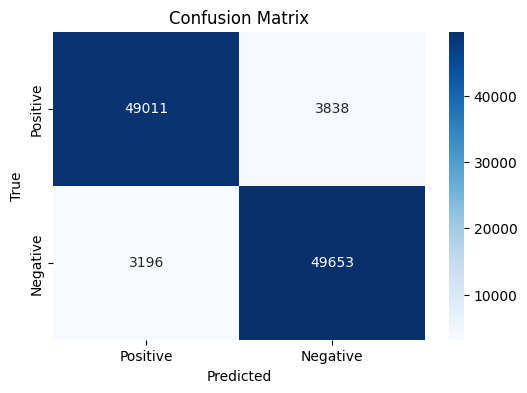

Predictions saved to model_predictions.csv.


In [8]:
# Load the reviews data with the correct encoding
file_path = 'HARD-Arabic-Dataset-master/data/balanced-reviews.txt'  # Update with your actual file path
df = pd.read_csv(file_path, sep='\t', names=['no', 'Hotel name', 'rating', 'user type', 'room type', 'nights', 'review'], skiprows=1, encoding='utf-16')

# Filter reviews with ratings 1, 2, 4, and 5
df_filtered = df[df['rating'].isin([1, 2, 4, 5])]

# Limit the number of reviews
# df_filtered = df_filtered.head(5000)

# Function to classify reviews based on the rating
def classify_review(row):
    if row['rating'] in [4, 5]:
        return 'Positive'
    elif row['rating'] in [1, 2]:
        return 'Negative'

# Apply classification function to the dataset
df_filtered['classification'] = df_filtered.apply(classify_review, axis=1)

# Load pre-trained tokenizer and model for Arabic BERT
tokenizer = AutoTokenizer.from_pretrained("aubmindlab/bert-base-arabertv02")
model = AutoModelForSequenceClassification.from_pretrained("arabic_bert_review_classifier")  # Load the trained model

# Use GPU if available for faster performance
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Function to predict classifications in batches with progress bar
def predict_in_batches(reviews, batch_size):
    predictions = []
    for i in tqdm(range(0, len(reviews), batch_size), desc="Processing Batches", unit="batch"):
        batch_reviews = reviews[i:i + batch_size]
        inputs = tokenizer(batch_reviews, padding='max_length', truncation=True, return_tensors='pt', max_length=512).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
            preds = np.argmax(outputs.logits.cpu().numpy(), axis=1)  # Move to CPU before converting to NumPy
            predictions.extend(preds)
    return predictions

# Predict classifications for all reviews in batches
predictions = predict_in_batches(df_filtered['review'].tolist(), batch_size=64)

# Map the predictions to the corresponding labels
df_filtered['model_classification'] = ['Positive' if pred == 1 else 'Negative' for pred in predictions]
df_filtered['model_correct'] = df_filtered['classification'] == df_filtered['model_classification']

# Calculate accuracy
accuracy = df_filtered['model_correct'].mean() * 100
print(f"Model Accuracy: {accuracy:.2f}%")

# Generate confusion matrix
y_true = df_filtered['classification']
y_pred = df_filtered['model_classification']
cm = confusion_matrix(y_true, y_pred, labels=['Positive', 'Negative'])

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Positive', 'Negative'], yticklabels=['Positive', 'Negative'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Select necessary columns for the final output
output_df = df_filtered[['no', 'Hotel name', 'rating', 'user type', 'room type', 'nights', 'review', 'classification', 'model_classification', 'model_correct']]

# Save the final DataFrame to a CSV file
output_file = 'model_predictions.csv'
output_df.to_csv(output_file, index=False, encoding='utf-16')

print(f"Predictions saved to {output_file}.")

### Display Examples of True Positive, True Negative, False Positive, and False Negative
This block defines conditions for four classification outcomes: True Positive, True Negative, False Positive, and False Negative. It then selects 5 review examples from each category and prints their review ID, rating, review text, model's predicted classification, and the true classification for comparison.


In [9]:
# Define conditions for True Positive, True Negative, False Positive, and False Negative
true_positive = df_filtered[(df_filtered['classification'] == 'Positive') & (df_filtered['model_classification'] == 'Positive')]
true_negative = df_filtered[(df_filtered['classification'] == 'Negative') & (df_filtered['model_classification'] == 'Negative')]
false_positive = df_filtered[(df_filtered['classification'] == 'Negative') & (df_filtered['model_classification'] == 'Positive')]
false_negative = df_filtered[(df_filtered['classification'] == 'Positive') & (df_filtered['model_classification'] == 'Negative')]

# Function to display 5 examples for each case
def display_examples(df, case_name):
    print(f"\n{case_name} Examples:")
    for index, row in df.head(5).iterrows():
        print(f"Review ID: {row['no']}")
        print(f"Rating: {row['rating']}")
        print(f"Review: {row['review']}")
        print(f"Model Classification: {row['model_classification']}")
        print(f"True Classification: {row['classification']}")
        print("-" * 80)

# Display 5 examples of each case
display_examples(true_positive, "True Positive")
display_examples(true_negative, "True Negative")
display_examples(false_positive, "False Positive")
display_examples(false_negative, "False Negative")



True Positive Examples:
Review ID: 3
Rating: 5
Review: استثنائي. سهولة إنهاء المعاملة في الاستقبال. لاشيئ
Model Classification: Positive
True Classification: Positive
--------------------------------------------------------------------------------
Review ID: 16
Rating: 5
Review: استثنائي. انصح بأختيار الاسويت و بالاخص غرفه رقم 801. نوعية الارضيه
Model Classification: Positive
True Classification: Positive
--------------------------------------------------------------------------------
Review ID: 23
Rating: 4
Review: جيد. المكان جميل وهاديء. كل شي جيد ونظيف بس كان حوض السباحه لايعمل في هذي الفتره حسب كلامهم يقولوا فيه صيانه والله اعلم
Model Classification: Positive
True Classification: Positive
--------------------------------------------------------------------------------
Review ID: 24
Rating: 5
Review: ممتاز. موقع الفندق ونظافته والاطلاله على البحر وجزيرة  النور التي تحتوي على الفراشات وكذلك قربه من المسجد والممشى  توفر المواقف بجانب الفندق وخدمة صف السيارات. المسبح كان مغلق للصيانه